# Boston Housing

In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## 1. Import Data

In [2]:
boston = pd.read_csv("train.csv")
print(boston.head())
print()
print(boston.describe())
print()
print(boston.info())

   ID     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  \
0   1  7.52601   0.0  18.10     0  0.713  6.417  98.3  2.1850   24  666   
1   2  0.01360  75.0   4.00     0  0.410  5.888  47.6  7.3197    3  469   
2   3  0.05789  12.5   6.07     0  0.409  5.878  21.4  6.4980    4  345   
3   4  0.05646   0.0  12.83     0  0.437  6.232  53.7  5.0141    5  398   
4   5  2.14918   0.0  19.58     0  0.871  5.709  98.5  1.6232    5  403   

   PTRATIO       B  LSTAT  MEDV  
0     20.2  304.21  19.31  13.0  
1     21.1  396.90  14.80  18.9  
2     18.9  396.21   8.10  22.0  
3     18.7  386.40  12.34  21.2  
4     14.7  261.95  15.79  19.4  

               ID        CRIM          ZN       INDUS        CHAS         NOX  \
count  406.000000  406.000000  406.000000  406.000000  406.000000  406.000000   
mean   203.500000    3.827366   11.623153   11.316305    0.076355    0.557776   
std    117.346353    9.109085   24.402026    6.863974    0.265892    0.117979   
min      1.000000   

In [3]:
# count the null columns
null_columns = boston.columns[boston.isnull().any()]
boston[null_columns].isnull().sum()

Series([], dtype: float64)

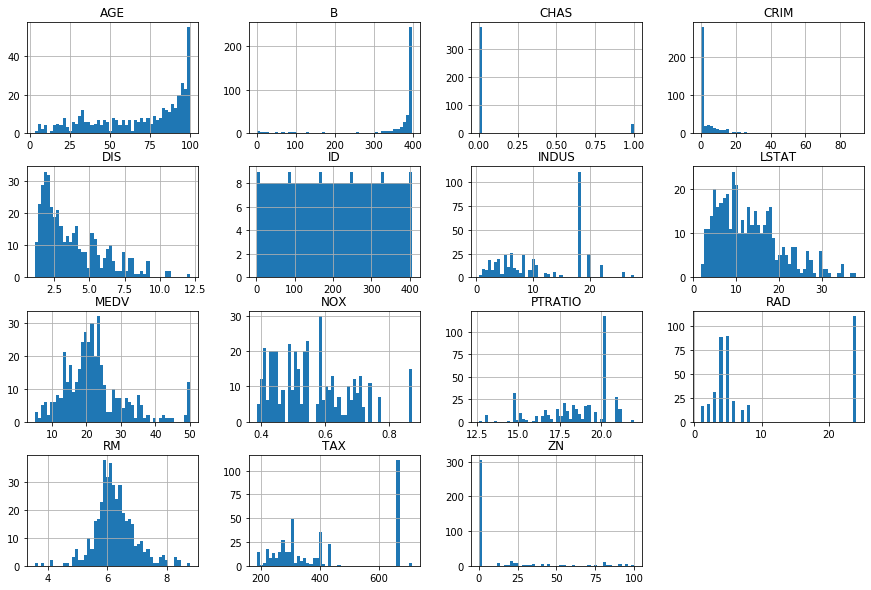

In [4]:
boston.hist(bins=50, figsize=(15, 10))
plt.show()

In [5]:
X = boston.iloc[:, 1:-1]
y = boston['MEDV']

## 2. Visualization

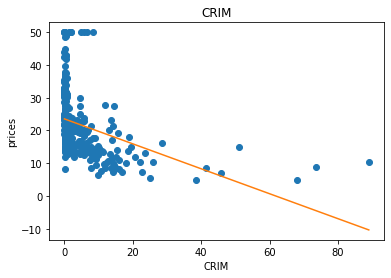

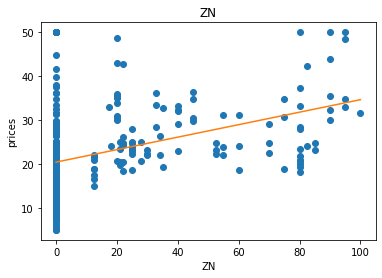

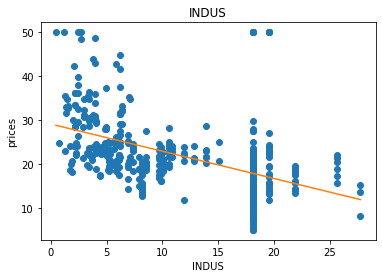

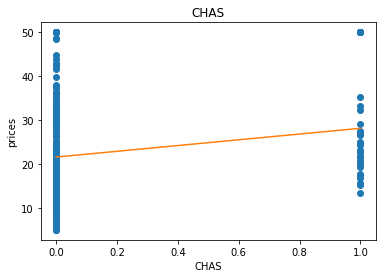

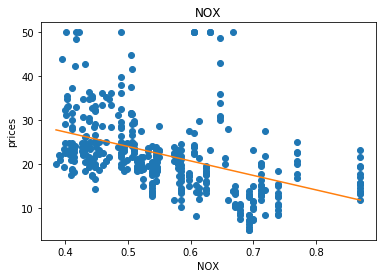

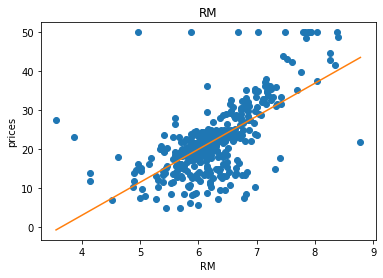

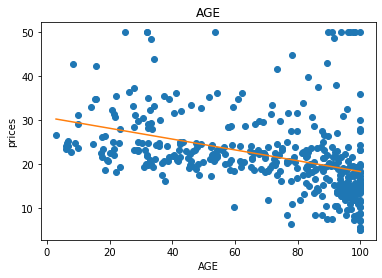

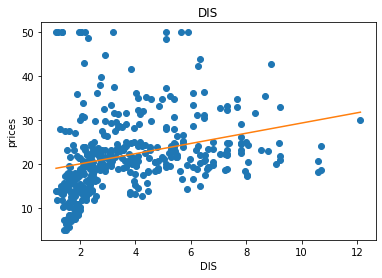

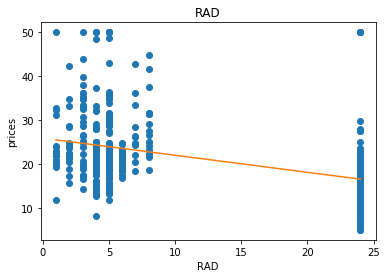

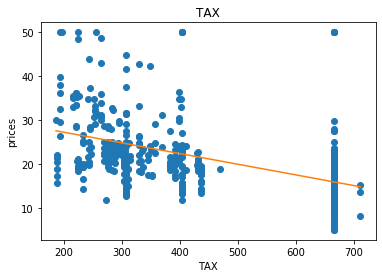

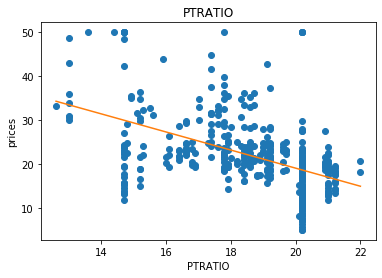

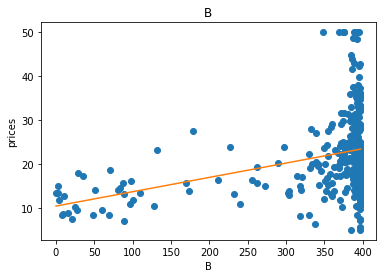

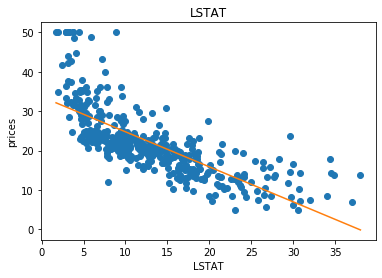

In [6]:
for i, col in enumerate(X.columns):
    x = boston[col]
    plt.plot(x, y, 'o')
    # create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
    plt.show()

## 3. Check Feature Importance

In [7]:
xgbr = xgb.XGBRegressor()

In [8]:
xgbr.fit(X, y)

[18:58:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/ccc/anaconda3/envs/mlnote/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ccc/anaconda3/envs/mlnote/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [9]:
xgbr.get_booster().get_score(importance_type='gain')

{'LSTAT': 1170.5912806284505,
 'RM': 407.86173977156585,
 'NOX': 114.57274366695417,
 'CRIM': 48.06237422548619,
 'DIS': 65.78717631524752,
 'PTRATIO': 109.93901440305558,
 'AGE': 26.895764984946428,
 'TAX': 56.70414882315789,
 'B': 30.702484215217385,
 'INDUS': 15.392935187827584,
 'CHAS': 45.74311416166666,
 'RAD': 18.774944386363632,
 'ZN': 9.174343283333334}

We can know the most three important features: `lstat`, `rm`, and `ptratio`

## 4. Build Model

According to sklearn [cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), I am going to try LASSO first.

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

lasso = Lasso(alpha=0.1)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [12]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
predictions = lasso.predict(X_val)

In [14]:
# apply MAE and MSE to evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("MAE: ", mean_absolute_error(predictions, y_val))
print("MSE: ", mean_squared_error(predictions, y_val))

MAE:  3.476493725286929
MSE:  37.58208376452703


I then try Lasso with cross validation since the dataset is pretty small.

In [15]:
from sklearn.linear_model import LassoCV

lassoCV = LassoCV(cv=5, random_state=42)
lassoCV.fit(X, y)
predictions_cv = lassoCV.predict(X_val)

print("MAE: ", mean_absolute_error(predictions_cv, y_val))
print("MSE: ", mean_squared_error(predictions_cv, y_val))

MAE:  3.5105838573811146
MSE:  31.7307861917697


## 5. Generate the Results of Competition

In [16]:
df_test = pd.read_csv("test.csv")
results = lassoCV.predict(df_test.iloc[:, 1:])

df_results = pd.DataFrame({"ID": df_test['ID'], "MEDV": results})
print(df_results.head())

pd.DataFrame(df_results).to_csv("submit_CudaChen.csv", index=False)

    ID       MEDV
0  407  28.391261
1  408  19.589200
2  409  11.207819
3  410  15.499903
4  411  21.230237
